Fold 1:
  MSE = 119.82
  R²  = 0.8075
  Best iteration (early stopping round) = 12
------------------------------
Fold 2:
  MSE = 17208.77
  R²  = -2.8198
  Best iteration (early stopping round) = 20
------------------------------
Fold 3:
  MSE = 13753.31
  R²  = -7.7714
  Best iteration (early stopping round) = 49
------------------------------
Fold 4:
  MSE = 9764.22
  R²  = -3.6200
  Best iteration (early stopping round) = 72
------------------------------
Fold 5:
  MSE = 0.07
  R²  = nan
  Best iteration (early stopping round) = 20
------------------------------


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


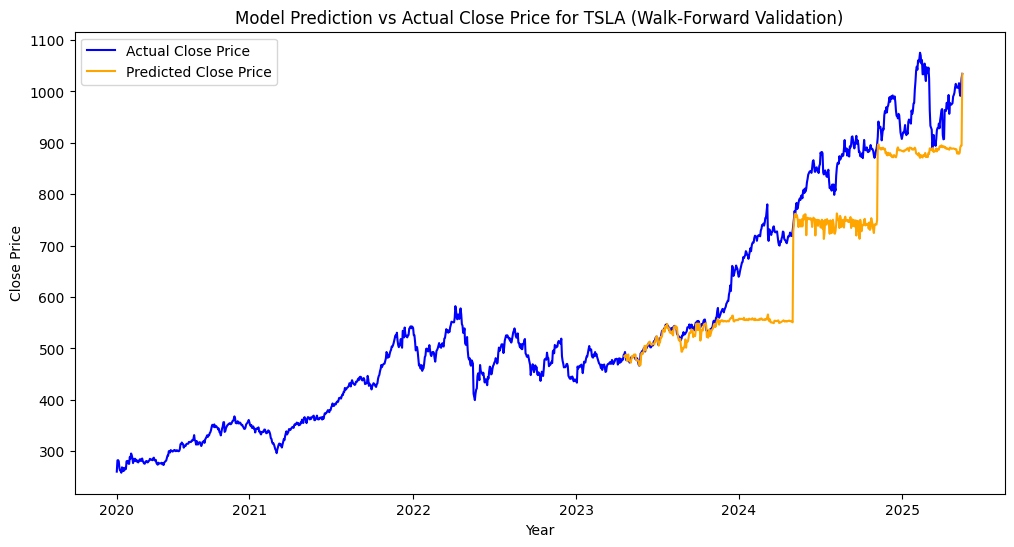

In [ ]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import numpy as np
import matplotlib.pyplot as plt


# Load data
data = pd.read_csv('../data/processed_data.csv')

# Convert columns to numeric (replace invalid parsing with NaN)
for col in ['Close', 'High', 'Low', 'Open', 'Volume']:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Drop NaNs
data.dropna(inplace=True)

# Create target: next-day close price
data['Target'] = data['Close'].shift(-1)
data.dropna(inplace=True)  # Drop the final NaN row

# Define features and target
X = data.drop(['Target'], axis=1)
y = data['Target']

# Parameters for walk-forward validation
initial_train_size = int(len(X) * 0.6)  # train on first 60% of data
step_size = int(len(X) * 0.1)           # test on next 10% each iteration

mse_scores = []
r2_scores = []

all_preds = np.full(len(y), np.nan)  # initialize all predictions as NaN
all_actuals = y.copy()

best_iterations = []

start = initial_train_size
while start < len(X):
    train_index = range(0, start)
    test_index = range(start, min(start + step_size, len(X)))

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = XGBRegressor(
        n_jobs=-1,
        n_estimators=1000,
        early_stopping_rounds=50,
        random_state=42
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False
    )

    predictions = model.predict(X_test)
    all_preds[test_index] = predictions

    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    mse_scores.append(mse)
    r2_scores.append(r2)

    best_iterations.append(model.best_iteration)

    fold_num = len(mse_scores)
    print(f"Fold {fold_num}:")
    print(f"  MSE = {mse:.2f}")
    print(f"  R²  = {r2:.4f}")
    print(f"  Best iteration (early stopping round) = {model.best_iteration}")
    print("-" * 30)

    start += step_size  # roll forward

# Plot data
years = data['Year'].values

plt.figure(figsize=(12,6))
plt.plot(all_actuals.values, label='Actual Close Price', color='blue')
plt.plot(all_preds, label='Predicted Close Price', color='orange')
plt.title('Model Prediction vs Actual Close Price for TSLA (Walk-Forward Validation)')
plt.xlabel('Year')
plt.ylabel('Close Price')
plt.legend()

unique_years, indices = np.unique(years, return_index=True)
unique_years_int = unique_years.astype(int)

plt.xticks(ticks=indices, labels=unique_years_int)
plt.show()

 